# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [31]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Business Understanding



Offers can be delivered via multiple channels. To better offer offers, following problems will be addressed during the analysis.
1. identify which groups of people are most responsive to each type of offer
1. figure out how best to present each type of offer.

1. Who would make purchase without receiving any offer?

# Data Understanding

To answer above questions, transaction, demographic and offer data are needed. 

Here are tables we have and their briefs:
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.) (10 offers x 6 fields)
* profile.json - demographic data for each customer (17000 users x 5 felds)
* transcript.json - records for transactions, offers received, offers viewed, and offers completed (306648 events x 4 fields)

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Portfolio

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# Expande channels into multi-columns

channels = ["web", "email", "mobile", "social"]

for col in channels:
    portfolio[col] = portfolio["channels"].apply(lambda x: 1 if col in x else 0)
    
portfolio[["channels", "web", "email", "mobile", "social"]]

,channels,web,email,mobile,social
0,"[email, mobile, social]",0,1,1,1
1,"[web, email, mobile, social]",1,1,1,1
2,"[web, email, mobile]",1,1,1,0
3,"[web, email, mobile]",1,1,1,0
4,"[web, email]",1,1,0,0
5,"[web, email, mobile, social]",1,1,1,1
6,"[web, email, mobile, social]",1,1,1,1
7,"[email, mobile, social]",0,1,1,1
8,"[web, email, mobile, social]",1,1,1,1
9,"[web, email, mobile]",1,1,1,0


## Profile

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [52]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [51]:
profile.isnull().sum(axis = 1).value_counts()

0    14825
2     2175
dtype: int64

1. There are 17000 profiles.
1. There are no missing values in columns age, id, and became_member_on, but are some missing values in columns gender and income.
1. 14825 profiles (87%) have no missing values, and 2175 (13%) have two missing values.

## became_member_on

In [55]:
profile["became_member_on"].apply(lambda x: str(x)[:4]).value_counts().to_frame("count").T

,2017,2018,2016,2015,2014,2013
count,6469,4198,3526,1830,691,286


## Age

In [29]:
profile[["age"]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,62.531412,26.73858,18.0,45.0,58.0,73.0,118.0


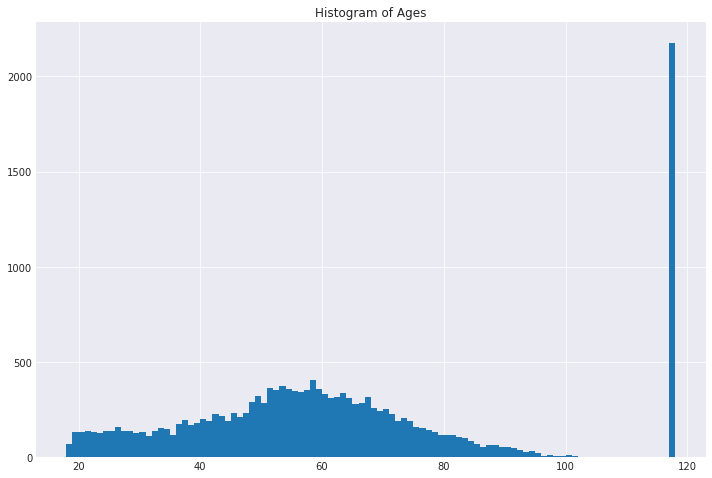

In [32]:
profile.age.hist(bins = 100, figsize = (12, 8));
plt.title("Histogram of Ages", fontsize = 12);

1. Ages are mainly between 20ish and 100ish.  
1. There do have many ages around 118.

Considering the distance between ages greater than 110 and other ages, would check their other columns separately.

In [36]:
profile_invalid = profile[profile["age"] >= 110]
profile_valid = profile[profile["age"] < 110]

## Gender & Income

In [48]:
# Check missing values of each person in both profile dataframes

## with valid ages, age < 110
profile_valid.isnull().sum(axis = 1).value_counts()

0    14825
dtype: int64

In [49]:
## with invalid ages, age >= 110
profile_invalid.isnull().sum(axis = 1).value_counts()

2    2175
dtype: int64

1. Profiles with **valid** age none of them has missing values in gender and income, 
1. Profiles with **invalid** age all have missing values in gender and income.

Will drop profiles with invalid ages in future analysis.

In [78]:
profile[["income"]].describe().T

,count,mean,std,min,25%,50%,75%,max
income,14825.0,65404.991568,21598.29941,30000.0,49000.0,64000.0,80000.0,120000.0


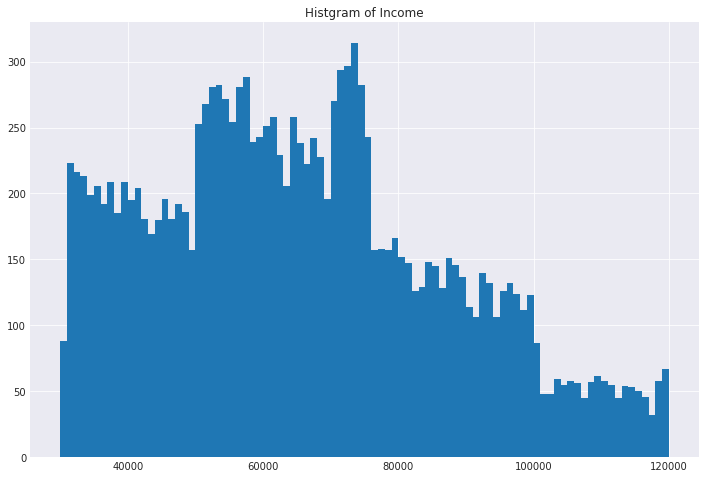

In [76]:
profile.income.hist(bins = 90, figsize = (12,8));
plt.title("Histgram of Income", fontsize = 12);

Income seems to be skewed, but there is no obvious outliers.

In [79]:
profile_valid.groupby("gender").agg({"id": ["count"], 
                                     "age": ["min", "max", "median", "mean"],
                                     "income": ["min", "max", "median", "mean"]})

id age                          income                     \
       count min  max median       mean      min       max   median   
gender                                                                
F       6129  18  101     58  57.544950  30000.0  120000.0  71000.0   
M       8484  18  100     53  52.116690  30000.0  120000.0  59000.0   
O        212  20  100     55  54.400943  30000.0  100000.0  62000.0   

                      
                mean  
gender                
F       71306.412139  
M       61194.601603  
O       63287.735849

## Transcript

In [80]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [91]:
transcript.groupby("event")["time"].describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
offer completed,33579.0,401.052801,192.352614,0.0,240.0,432.0,564.0,714.0
offer received,76277.0,332.579519,196.489548,0.0,168.0,408.0,504.0,576.0
offer viewed,57725.0,354.290515,199.317684,0.0,180.0,408.0,516.0,714.0
transaction,138953.0,381.584334,201.697230,0.0,210.0,402.0,552.0,714.0


In [92]:
transcript[transcript["person"] == "78afa995795e4d85b5d9ceeca43f5fef"]

,event,person,time,value,transcript_offer_id,transcript_amount,transcript_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},NaN,19.89,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},NaN,17.78,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},NaN,19.67,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},NaN,29.72,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},NaN,23.93,NaN


In [97]:
portfolio.query('id == "f19421c1d4aa40978ebb69ca19b0e20d"')

,channels,difficulty,duration,id,offer_type,reward,web,email,mobile,social
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1


## Value

In [81]:
# Check Keys in column value
transcript.value.apply(lambda x: x.keys()).value_counts()

(amount)              138952
(offer id)            134001
(offer_id, reward)     33578
(offer id)                 1
(offer_id, reward)         1
(amount)                   1
Name: value, dtype: int64

In [82]:
transcript["transcript_offer_id"] = transcript["value"].apply(lambda x: x.get("offer id") if "offer id" in x.keys() else
                                                             x.get("offer_id") if "offer_id" in x.keys() else 
                                                             np.nan)
transcript["transcript_amount"] = transcript["value"].apply(lambda x: x.get("amount"))
transcript["transcript_reward"] = transcript["value"].apply(lambda x: x.get("reward"))

In [83]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
event                  306534 non-null object
person                 306534 non-null object
time                   306534 non-null int64
value                  306534 non-null object
transcript_offer_id    167581 non-null object
transcript_amount      138953 non-null float64
transcript_reward      33579 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB


In [84]:
transcript.head()

,event,person,time,value,transcript_offer_id,transcript_amount,transcript_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [91]:
transcript.query('event == "offer received"').groupby(["transcript_offer_id", "person"])["person"].count()\
.sort_values(ascending = False).value_counts()

1    51570
2    10523
3     1124
4       66
5        5
Name: person, dtype: int64

## event

In [86]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [90]:
transcript.groupby("event")["transcript_offer_id"].count()

event
offer completed    33579
offer received     76277
offer viewed       57725
transaction            0
Name: transcript_offer_id, dtype: int64

In [87]:
received = transcript[transcript["event"] == "offer received"][["person", "transcript_offer_id"]].drop_duplicates(keep = "first")
viewed = transcript[transcript["event"] == "offer viewed"][["person", "transcript_offer_id"]].drop_duplicates(keep = "first")
completed = transcript[transcript["event"] == "offer completed"][["person", "transcript_offer_id"]].drop_duplicates(keep = "first")

offers = received\
.merge(viewed, how = "outer", on = ["person", "transcript_offer_id"], indicator = True).rename(columns = {"_merge": "is_viewed"})\
.merge(completed, how = "outer", on = ["person", "transcript_offer_id"], indicator = True).rename(columns = {"_merge": "is_completed"})\

In [35]:
offers.head()

,person,transcript_offer_id,is_viewed,is_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,both,both
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,both,left_only
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,both,left_only
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,both,left_only
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,both,left_only


In [36]:
offers[["is_viewed", "is_completed"]].drop_duplicates(keep = "first")

,is_viewed,is_completed
0,both,both
1,both,left_only
7,left_only,left_only
20,left_only,both


In [37]:
offers["is_completed"] = offers.apply(lambda row: 
"viewed_completed" if (row["is_viewed"] == "both") & (row["is_completed"] == "both") else
"viewed_not_completed" if (row["is_viewed"] == "both") & (row["is_completed"] == "left_only") else
"not_viewed_completed" if (row["is_viewed"] == "left_only") & (row["is_completed"] == "both") else
"not_viewed_not_completed" if (row["is_viewed"] == "left_only") & (row["is_completed"] == "left_only") else
np.nan, axis = 1)


In [38]:
offers["is_viewed"] = offers["is_viewed"].apply(lambda x: "viewed" if x == "both" else
                                                          "not_viewed" if x == "left_only" else 
                                                          np.nan)

In [39]:
offers["is_viewed"].value_counts()

viewed        49135
not_viewed    14153
Name: is_viewed, dtype: int64

In [40]:
offers["is_completed"].value_counts()

viewed_not_completed        24675
viewed_completed            24460
not_viewed_not_completed     9617
not_viewed_completed         4536
Name: is_completed, dtype: int64

In [41]:
offers[["is_viewed", "is_completed"]].drop_duplicates(keep = "first")

,is_viewed,is_completed
0,viewed,viewed_completed
1,viewed,viewed_not_completed
7,not_viewed,not_viewed_not_completed
20,not_viewed,not_viewed_completed


profile

每个人对不同类型的offer的反应
比如说，


| |  BOGO | Discount| Information |
|---|---|---|---|
| | viewed_Pct | Completed_Pct | viewed_Pct | Completed_Pct | viewed_Pct | Completed_Pct | 
| 001 | 100% | 50% | 80% | 50% | 10% |


2017    6469
2018    4198
2016    3526
2015    1830
2014     691
2013     286
Name: became_member_on, dtype: int64

# Data Preparation



## Combine All 3 DataFrames

In [66]:
df = transcript.drop("value", axis = 1)\
.merge(portfolio.drop("channels", axis = 1), 
       how = "left", left_on = "transcript_offer_id", right_on = "id").drop("id", axis = 1)\
.merge(profile, how = "left", left_on = "person", right_on = "id").drop("id", axis = 1)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 18 columns):
event                  306534 non-null object
person                 306534 non-null object
time                   306534 non-null int64
transcript_offer_id    167581 non-null object
transcript_amount      138953 non-null float64
transcript_reward      33579 non-null float64
difficulty             167581 non-null float64
duration               167581 non-null float64
offer_type             167581 non-null object
reward                 167581 non-null float64
web                    167581 non-null float64
email                  167581 non-null float64
mobile                 167581 non-null float64
social                 167581 non-null float64
age                    306534 non-null int64
became_member_on       306534 non-null int64
gender                 272762 non-null object
income                 272762 non-null float64
dtypes: float64(10), int64(3), object(5)
memory usage: 

In [68]:
df.head(3)

,event,person,time,transcript_offer_id,transcript_amount,transcript_reward,difficulty,duration,offer_type,reward,web,email,mobile,social,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,75,20170509,F,100000.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0,118,20170804,None,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0,68,20180426,M,70000.0


In [76]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward',
       'web', 'email', 'mobile', 'social'],
      dtype='object')

In [80]:
offer_funnel = df.groupby(["transcript_offer_id", "difficulty", "duration", "offer_type", "reward",
       "web", "email", "mobile", "social", "event"])["person"].count().unstack().reset_index()

offer_funnel["view2received"] = 1.0 * offer_funnel["offer viewed"]/offer_funnel["offer received"]
offer_funnel["completed2received"] = 1.0 * offer_funnel["offer completed"]/offer_funnel["offer received"]
offer_funnel["completed2view"] = 1.0 * offer_funnel["offer completed"]/offer_funnel["offer viewed"]

offer_funnel.sort_values(["completed2view", "completed2received", "view2received"], ascending = [False, False, False])

event,transcript_offer_id,difficulty,duration,offer_type,reward,web,email,mobile,social,offer completed,offer received,offer viewed,view2received,completed2received,completed2view
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,1.0,1.0,0.0,0.0,3420.0,7668.0,2663.0,0.347287,0.446009,1.284266
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0,4354.0,7677.0,4171.0,0.543311,0.567149,1.043874
2,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0,4017.0,7632.0,4118.0,0.539570,0.526336,0.975474
9,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0,5317.0,7597.0,7327.0,0.964460,0.699882,0.725672
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0,5156.0,7646.0,7337.0,0.959587,0.674340,0.702740
8,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,4296.0,7571.0,7264.0,0.959451,0.567428,0.591410
7,ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,bogo,10.0,0.0,1.0,1.0,1.0,3688.0,7658.0,6716.0,0.876991,0.481588,0.549136
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0,3331.0,7593.0,7298.0,0.961148,0.438694,0.456426
5,5a8bc65990b245e5a138643cd4eb9837,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,NaN,7618.0,6687.0,0.877789,NaN,NaN
3,3f207df678b143eea3cee63160fa8bed,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0,NaN,7617.0,4144.0,0.544046,NaN,NaN


In [100]:
# Separate (Person, Offer) for which offer is not Viewed but is completed

offer_viewed = df[df["event"] == "offer viewed"][["person", "transcript_offer_id"]].drop_duplicates(keep = "first")
offer_completed = df[df["event"] == "offer completed"][["person", "transcript_offer_id"]].drop_duplicates(keep = "first")

offer_details = offer_viewed.merge(offer_completed
                                   , how = "outer", on = ["person", "transcript_offer_id"]
                                   , indicator = True)

In [102]:
offer_details["details"] = \
offer_details["_merge"].apply(lambda x: "viewed_and_completed" if x == "both" else
                                        "viewed_not_completed" if x == "left_only" else 
                                        "not_viewed_but_completed")

In [101]:
offer_details["_merge"].value_counts()

left_only     24675
both          24460
right_only     4536
Name: _merge, dtype: int64

In [103]:
offer_details

,person,transcript_offer_id,_merge,details
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,both,viewed_and_completed
1,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,left_only,viewed_not_completed
2,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,both,viewed_and_completed
3,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,left_only,viewed_not_completed
4,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,left_only,viewed_not_completed
5,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,both,viewed_and_completed
6,8c7df0c393db488aac3e58b06a7ea5f9,2298d6c36e964ae4a3e7e9706d1fb8c2,both,viewed_and_completed
7,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2,left_only,viewed_not_completed
8,262ad0fb526a4d53b572007da60cce24,f19421c1d4aa40978ebb69ca19b0e20d,left_only,viewed_not_completed
9,53bac762af27471eb294ff89ca1bae2c,fafdcd668e3743c1bb461111dcafc2a4,both,viewed_and_completed


In [83]:
offer_viewed.shape

(49135, 2)

In [85]:
df[df["event"] == "offer viewed"][["person", "transcript_offer_id", "event"]].groupby(["person", "transcript_offer_id"])["event"].count().sort_values(ascending = False).head()

person                            transcript_offer_id             
6d2db3aad94648259e539920fc2cf2a6  f19421c1d4aa40978ebb69ca19b0e20d    5
2ea50de315514ccaa5079db4c1ecbc0b  fafdcd668e3743c1bb461111dcafc2a4    5
eece6a9a7bdd4ea1b0f812f34fc619d6  5a8bc65990b245e5a138643cd4eb9837    5
23d67a23296a485781e69c109a10a1cf  5a8bc65990b245e5a138643cd4eb9837    5
671a142bc07e47389b920cb0c37793bd  4d5c57ea9a6940dd891ad53e9dbe8da0    4
Name: event, dtype: int64

In [86]:
df.query('person == "6d2db3aad94648259e539920fc2cf2a6"').query('transcript_offer_id == "f19421c1d4aa40978ebb69ca19b0e20d"')

,event,person,time,transcript_offer_id,transcript_amount,transcript_reward,difficulty,duration,offer_type,reward,web,email,mobile,social,age,became_member_on,gender,income
3956,offer received,6d2db3aad94648259e539920fc2cf2a6,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
12983,offer viewed,6d2db3aad94648259e539920fc2cf2a6,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
57195,offer received,6d2db3aad94648259e539920fc2cf2a6,168,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
66266,offer viewed,6d2db3aad94648259e539920fc2cf2a6,168,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
114863,offer received,6d2db3aad94648259e539920fc2cf2a6,336,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
123986,offer viewed,6d2db3aad94648259e539920fc2cf2a6,336,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
154613,offer received,6d2db3aad94648259e539920fc2cf2a6,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
163897,offer viewed,6d2db3aad94648259e539920fc2cf2a6,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
189466,offer completed,6d2db3aad94648259e539920fc2cf2a6,462,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0
249107,offer received,6d2db3aad94648259e539920fc2cf2a6,576,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,82,20180411,M,65000.0


In [ ]:
one offer will be sent for multiple times

# Modeling




# Evaluation





# Deployment



